In [1]:
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from operator import gt, lt
from mpl_toolkits import axes_grid1
import matplotlib.image as mpimg
import matplotlib as mpl

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.size": 12
    }
)

sns.set_palette("colorblind")

### Fig. 6

In [2]:
dfs = []
for file in glob("../binning/*_*/*.tsv"):
    df = pd.read_csv(file, sep="\t")
    group, sample = file.split("/")[2:]
    sample = sample.split("_")[0]
    group, strategy = group.split("_")
    df["group"] = group
    df["strategy"] = strategy.upper()
    if strategy.endswith("cb"):
        df["sample"] = "cobinning"
    dfs.append(df)
    

df = pd.concat(dfs).reset_index(drop=True)

drep = []

for file in glob("../binning/*_*/drep/data_tables/Wdb.csv"):
    strategy = file.split("_")[1].split("/")[0]
    df_ = pd.read_csv(file)
    df_["group"] = file.split("/")[2].split("_")[0]
    df_["strategy"] = strategy.upper()
    drep.append(df_)
    
drep = pd.concat(drep).reset_index(drop=True)

drep["sample"] = ""
drep["bin"] = ""

for ix, item in drep["genome"].items():
    drep.loc[ix, "bin"] = "_".join(item.split("_")[2:]).strip(".fa") if item.startswith("sample") else item.rstrip(".fa")
    drep.loc[ix, "sample"] = "_".join(item.split("_")[:2]) if item.startswith("sample") else "cobinning"

columns = ["group", "strategy", "sample", "bin"]

drep = df.merge(drep, right_on=columns, left_on=columns)
# drep["strategy"] = drep["strategy"] + " dereplicated"
df["dereplicated"] = False
drep["dereplicated"] = True
df = pd.concat([df, drep]).reset_index(drop=True)

In [3]:
scores = []
id_vars = ["group", "strategy", "dereplicated"]

for i in range(1,100):
    p = i/100
    # series = df[(df["group"] == "strmg") & (df["bin_score"] > p)].groupby("strategy").count().iloc[:, 0]
    counts = df[df["bin_score"] > p].groupby(id_vars).count().iloc[:, 0]
    sums = df[df["bin_score"] > p].groupby(id_vars).sum(numeric_only=True)["bin_score"]
    df_p = pd.concat([counts, sums], axis=1).reset_index()
    df_p["score >="] = p
    df_p = df_p.groupby(["score >=",] + id_vars).max()
    df_p.columns = ["number of bins", "cumulative bin score"]
    scores.append(df_p)
    
scores_df = pd.concat(scores, axis=1).reset_index().melt(["score >=",] + id_vars)

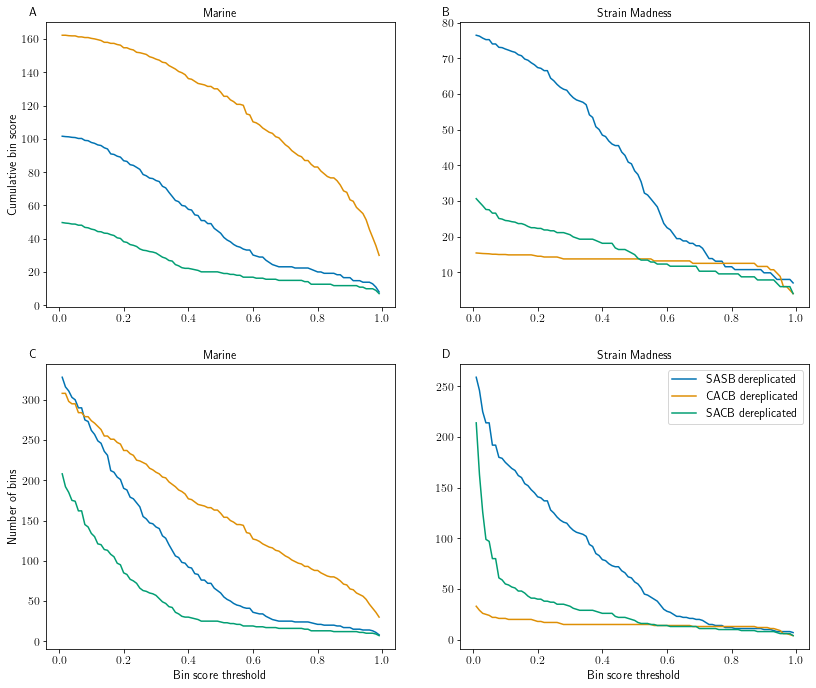

In [4]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.tight_layout(pad=3.0)
groups = ["marmg", "strmg"]
variables = ["cumulative bin score", "number of bins"]
hue_order = ["SASB dereplicated", "CACB dereplicated", "SACB dereplicated"]

for (x, y), letter in zip([(0, 0), (0, 1), (1, 0), (1, 1)], "ABCD"):
    ax, group, var = axs[x][y], groups[y], variables[x]
    plot_df = scores_df.query(f"group == '{group}' & variable == '{var}' & dereplicated == True")
    plot_df = plot_df.rename(columns={"strategy": "Strategy", "dereplicated": "Dereplicated"})
    plot_df["Strategy"] = plot_df["Strategy"] + " dereplicated"
    sns.lineplot(x="score >=", y="value", hue="Strategy", data=plot_df,  ax=ax, hue_order=hue_order, style_order=[True, False])
    handles, labels = ax.get_legend_handles_labels()
    # labels = [label + " (" + str(df.query("bin_score >= 0.25").groupby(["group", "strategy"]).count().loc[group, label][0]) + ")" for label in labels]
    ax.legend(handles, labels) if letter == "D" else ax.legend().set_visible(False)
    ax.set_ylabel(var.capitalize())
    ax.set_xlabel("Bin score threshold") if letter in "CD" else ax.set_xlabel("")
    ax.set_title(group.replace("marmg", "Marine").replace("strmg", "Strain Madness"), fontsize=12) # if letter in "AB" else ax.set_title("")
    ax.set_ylabel("") if letter in "BD" else ""
    ax.annotate(letter, xy=(-0.05,1.025), xycoords="axes fraction", fontsize=12, weight="bold")
    
plt.savefig("../figures/Fig6.png", dpi=600, bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})

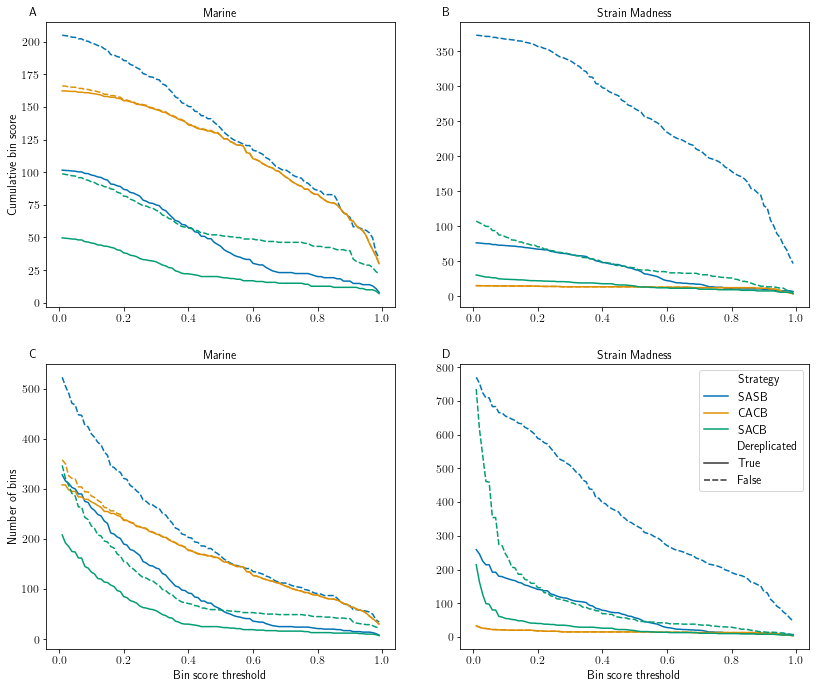

In [5]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.tight_layout(pad=3.0)
groups = ["marmg", "strmg"]
variables = ["cumulative bin score", "number of bins"]
hue_order = ["SASB", "CACB", "SACB"]

for (x, y), letter in zip([(0, 0), (0, 1), (1, 0), (1, 1)], "ABCD"):
    ax, group, var = axs[x][y], groups[y], variables[x]
    plot_df = scores_df.query(f"group == '{group}' & variable == '{var}' ")
    plot_df = plot_df.rename(columns={"strategy": "Strategy", "dereplicated": "Dereplicated"})
    sns.lineplot(x="score >=", y="value", hue="Strategy", style="Dereplicated", data=plot_df,  ax=ax, hue_order=hue_order, style_order=[True, False])
    handles, labels = ax.get_legend_handles_labels()
    # labels = [label + " (" + str(df.query("bin_score >= 0.25").groupby(["group", "strategy"]).count().loc[group, label][0]) + ")" for label in labels]
    ax.legend(handles, labels) if letter == "D" else ax.legend().set_visible(False)
    ax.set_ylabel(var.capitalize())
    ax.set_xlabel("Bin score threshold") if letter in "CD" else ax.set_xlabel("")
    ax.set_title(group.replace("marmg", "Marine").replace("strmg", "Strain Madness"), fontsize=12) # if letter in "AB" else ax.set_title("")
    ax.set_ylabel("") if letter in "BD" else ""
    ax.annotate(letter, xy=(-0.05,1.025), xycoords="axes fraction", fontsize=12, weight="bold")
    
plt.savefig("../figures/FigS4.png", dpi=400, bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})

### Fig. 2

In [6]:
!python /Users/vwsalazar/Bio/phd/metaphor/metaphor/workflow/scripts/bins_report.py --score-threshold 0.25 --bins-eval ../binning/marmg_cacb/cobinning_DASTool_summary.tsv --binning-group marmg_cacb --dpi 600

06/14/2023 14:24:52 Starting script 'bins_report.py'.
06/14/2023 14:24:52 Full script path: '/Users/vwsalazar/Bio/phd/metaphor/metaphor/workflow/scripts/bins_report.py'.

/Users/vwsalazar/Bio/phd/metaphor/metaphor/workflow/scripts/bins_report.py:34: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ix, value in df[column].value_counts().iteritems():
/Users/vwsalazar/Bio/phd/metaphor/metaphor/workflow/scripts/bins_report.py:34: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ix, value in df[column].value_counts().iteritems():
06/14/2023 14:24:53 Generated plot: 'output/binning/plots/marmg_cacb/bin_quality.png'.
06/14/2023 14:24:54 Generated plot: 'output/binning/plots/marmg_cacb/bin_scores.png'.
/Users/vwsalazar/Bio/phd/metaphor/metaphor/workflow/scripts/bins_report.py:167: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  plot_data.plot(

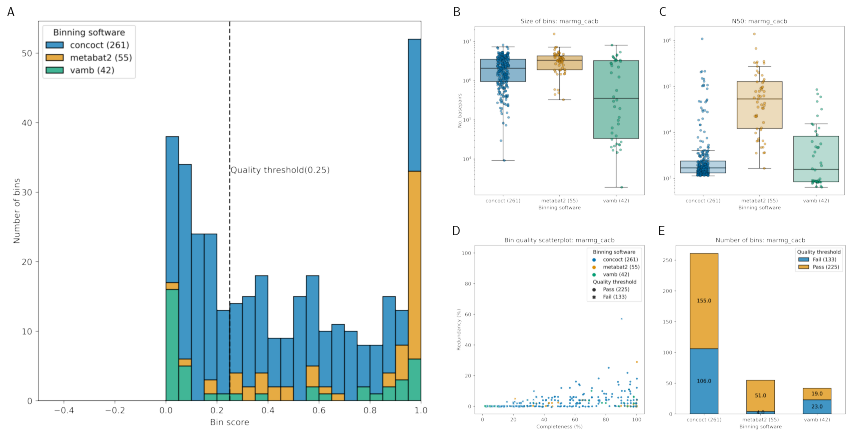

In [7]:
gs_kw = dict(width_ratios=[2.3, 1, 1], height_ratios=[1, 1])
    
fig, axd = plt.subplot_mosaic([['left', 'upper center', 'upper right'],
                               ['left', 'lower center', 'lower right']],
                              figsize=(12, 6), gridspec_kw=gs_kw, layout="constrained",)
                              # subplotpars=mpl.figure.SubplotParams(top=0, bottom=-0.01, right=0, left=-0.01, hspace=0, wspace=0))
im1 = "output/binning/plots/marmg_cacb/bin_scores.png"
im2 = "output/binning/plots/marmg_cacb/bin_sizes.png"
im3 = "output/binning/plots/marmg_cacb/bin_N50.png"
im4 = "output/binning/plots/marmg_cacb/bin_quality.png"
im5 = "output/binning/plots/marmg_cacb/bin_quantity.png"

for k, im, letter in zip(axd, [im1, im2, im3, im4, im5], "ABCDE"):
    im = mpimg.imread(im)
    axd[k].imshow(im, origin="lower")
    axd[k].invert_yaxis()
    axd[k].axes.get_xaxis().set_visible(False)
    axd[k].axes.get_yaxis().set_visible(False)
    axd[k].set_frame_on(False)
    axd[k].annotate(letter, xy=(0.0, 1), xycoords="axes fraction", fontsize=12, weight="bold")
    
plt.savefig("../figures/Fig2.png", dpi=600, bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})

### Fig. S3

In [8]:
df["group"] = df["group"].str.replace("marmg", "Marine").str.replace("strmg", "Strain Madness")
df["strategy_dereplicated"] = df.apply(lambda row: row["strategy"] + " dereplicated" if row["dereplicated"] else row["strategy"], axis=1)

In [9]:
def add_median_labels(ax, dereplicated):
    import matplotlib.patheffects as path_effects

    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for ix, median in enumerate(lines[4:len(lines):lines_per_box]):
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        
        # dereplicated values
        if dereplicated:
            value = [329, 308, 208, 259, 33, 215][ix]
        # non-dereplicated
        else:
            value = [524, 358, 347, 770, 33, 736][ix]
        text = ax.text(x, -0.02, f"n={int(value)}", ha='center', va='center')
        

def box_strip_plot(df, variable="bin_score", dereplicated=True, operator=gt, cutoff=None, add_strip=True, save=False, figsize=(12,12), hue="strategy_dereplicated", legend_loc="best"):
    fig, ax = plt.subplots(figsize=figsize)
    # ax.set_ylim(0.21, 1.05)
    
    if cutoff is not None:
        df = df[operator(df[variable], cutoff)]
      
    order = sorted(df.group.value_counts().index)
    if dereplicated:
        hue_order =["SASB dereplicated", "CACB dereplicated", "SACB dereplicated"]
        df = df.query("dereplicated == True")
    else:
        hue_order = ["SASB", "CACB", "SACB",]
        df = df.query("dereplicated == False")
    
    sns.boxplot(x="group", y=variable, hue=hue, data=df, ax=ax, order=order, fliersize=5 if add_strip else 0, hue_order=hue_order)
    if add_strip:
        sns.stripplot(x="group", y=variable, hue=hue, data=df, ax=ax, dodge=True, alpha=0.5, linewidth=0.5, order=order, hue_order=hue_order)
            
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
        
    add_median_labels(ax, dereplicated)
        
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:int(len(handles)/2)], labels[:int(len(labels)/2)], title="Strategy", loc=legend_loc, bbox_to_anchor=(1, 1, 0, 0))
    ax.set_ylabel(variable.capitalize().replace("_", " "))
    ax.set_xlabel("Dataset")
        
    if save:
        plt.savefig(save, dpi=600, bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})

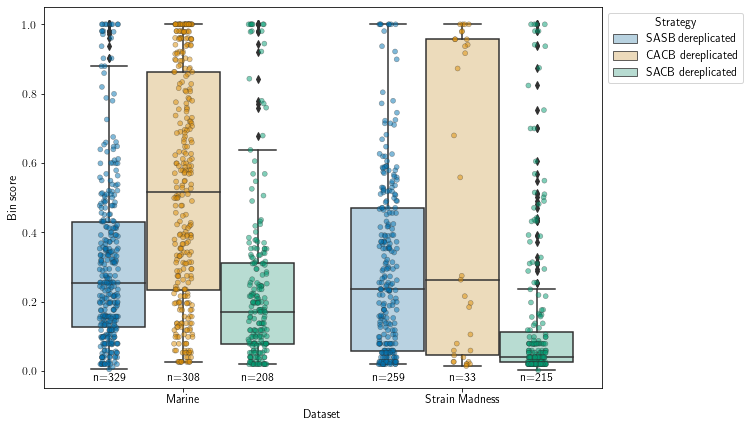

In [10]:
box_strip_plot(df, dereplicated=True, figsize=(10,7),hue="strategy_dereplicated", legend_loc="best", save="../figures/FigS2.png",)

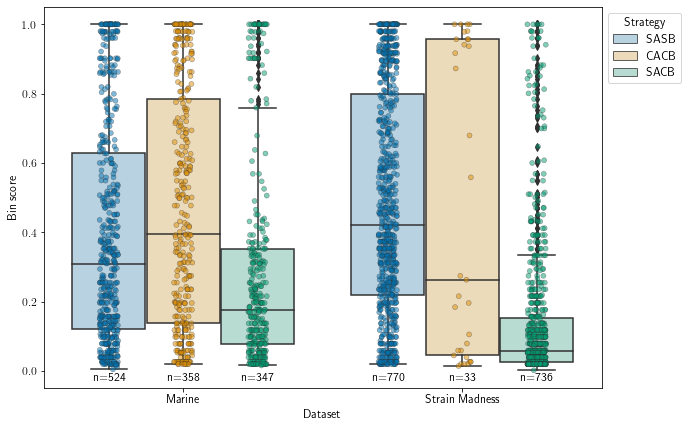

In [11]:
box_strip_plot(df, dereplicated=False, figsize=(10,7),hue="strategy_dereplicated", legend_loc="best", save="../figures/FigS3.png",)

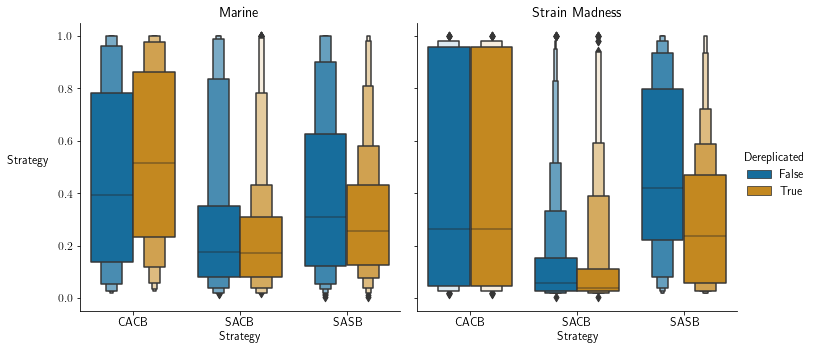

In [12]:
plot_df = df.rename(columns={i: i.capitalize().replace("_", " ") for i in df.columns})

grid = sns.catplot(data=plot_df,
                   x="Strategy",
                   y="Bin score",
                   hue="Dereplicated",
                   col="Group",
                   dodge=True,
                   kind="boxen",
                   sharex=True,
                   legend_out=True,
                   col_order=["Marine", "Strain Madness"],
                   order=["CACB", "SACB", "SASB"]
                  )

# sns.stripplot(data=plot_df.query("Group == 'strmg'"), y="Strategy", x="Bin score", hue="Dereplicated", dodge=True, ax=grid.axes_dict["strmg"])
# sns.stripplot(data=plot_df.query("Group == 'marmg'"), y="Strategy", x="Bin score", hue="Dereplicated", dodge=True, ax=grid.axes_dict["marmg"])

#     for patch in ax.patches:
#         r, g, b, a = patch.get_facecolor()
#         patch.set_facecolor((r, g, b, .3))
grid.set_ylabels("Strategy", rotation=0, labelpad=30)
for k, ax in grid.axes_dict.items():
    ax.set_title(k.replace("strmg", "Strain Madness").replace("marmg", "Marine"))
    
# plt.savefig("../figures/final/FigS2.tif", dpi=600, bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})